### ЛР № 6 Catboost

* Выполнил: Русин Ярослав, гр. № 6135

Используется датасет из предыдущей работы ( данные с автомобилями)


In [ ]:
! pip install catboost shap ipywidgets
! jupyter nbextension enable --py widgetsnbextension

     |████████████████████████████████| 69.2MB 56kB/s 
     |████████████████████████████████| 358kB 37.0MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491630 sha256=2c06414ecaeb581ac6d7f0037dbf14caf34b13d015ee01fe3ea711413c4ebe5c
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [ ]:
import pandas as pd
import numpy as np
np.set_printoptions(precision=4)
import catboost
from catboost import *
from catboost import datasets

import warnings
import sys  
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip  /content/drive/MyDrive/Datasets/machinedata.zip  -d data

Archive:  /content/drive/MyDrive/Datasets/machinedata.zip
  inflating: data/imports-85.txt     
  inflating: data/imports-85_inf.txt  


In [ ]:
machframe = pd.read_csv("/content/data/imports-85.txt",names=['symboling', 'normalized-losses', 'make', 'fuel-type', 
                                           'aspiration', 'num-of-doors','body-style','drive-wheels',
                                           'engine-location','wheel-base','length','width','height',
                                           'curb-weight','engine-type','num-of-cylinders','engine-size',
                                           'fuel-system','bore','stroke','compression-ratio','horsepower',
                                          'peak-rpm','city-mpg','highway-mpg','price'])
machframe.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


In [ ]:
fp = "/content/data/imports-85_inf.txt" # описание датасета
with open(fp) as file_handler:
    for line in file_handler:
        print(line)

1. Title: 1985 Auto Imports Database



2. Source Information:

   -- Creator/Donor: Jeffrey C. Schlimmer (Jeffrey.Schlimmer@a.gp.cs.cmu.edu)

   -- Date: 19 May 1987

   -- Sources:

     1) 1985 Model Import Car and Truck Specifications, 1985 Ward's

        Automotive Yearbook.

     2) Personal Auto Manuals, Insurance Services Office, 160 Water

        Street, New York, NY 10038 

     3) Insurance Collision Report, Insurance Institute for Highway

        Safety, Watergate 600, Washington, DC 20037



3. Past Usage:

   -- Kibler,~D., Aha,~D.~W., \& Albert,~M. (1989).  Instance-based prediction

      of real-valued attributes.  {\it Computational Intelligence}, {\it 5},

      51--57.

	 -- Predicted price of car using all numeric and Boolean attributes

	 -- Method: an instance-based learning (IBL) algorithm derived from a

	    localized k-nearest neighbor algorithm.  Compared with a

	    linear regression prediction...so all instances

	    with missing attribute values were

In [ ]:
machframe = machframe.drop(machframe[machframe['num-of-doors'] == '?'].index)
machframe = machframe[machframe[:] != '?'].iloc[:,:] #найдем все пропуски в данных и заменим их на медианный
machframe.fillna(machframe.median(),inplace = True)
machframe["num-of-doors"].unique() #проверим бинарный признак

array(['two', 'four'], dtype=object)

## CatBoostClassifier

Применить классификатор CatBoostClassifier к вашему датасету (бинарная или multiclass классификация по желанию).
Можно работать на тех же данных, что и в предыдущей Л.Р.: в этом случае сравнить с результатами лучшего классификатора из предыдущей работы.

In [ ]:
y = machframe["num-of-doors"]

In [ ]:
X = machframe.drop("num-of-doors", axis=1)

In [ ]:
cat_features = list([0,2,3,4,5,6,7,13,14,16]) #задаем колонки категориальных признаков
print(cat_features)

[0, 2, 3, 4, 5, 6, 7, 13, 14, 16]


In [ ]:
import sklearn.model_selection

In [ ]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, random_state = 0
)

In [ ]:
model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    loss_function='Logloss', 
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_test, y_test),
    verbose = False
    
)

print('Model is fitted: ' + str(model.is_fitted()))
print('Model params:')
print(model.get_params())

Model is fitted: True
Model params:
{'iterations': 100, 'learning_rate': 0.1, 'loss_function': 'Logloss'}


Вывести итерацию с наилучшим значением AUC (для бинарной классификации) или наилучшим значением Logloss.

In [ ]:
model.get_best_iteration() #итерация с наименьшим logloss

12

In [ ]:
model.best_score_ #значение на этой итерации

{'learn': {'Logloss': 0.02763345062205948},
 'validation': {'Logloss': 0.3717899272574765}}

Вывести значения метрик качества классификации на тестовых данных

In [ ]:
print(sklearn.metrics.classification_report( #смотрим на табличку метрик
    model.predict(X_test), y_test, target_names=["two", "four"]
) )

              precision    recall  f1-score   support

         two       0.96      0.79      0.86        28
        four       0.79      0.96      0.86        23

    accuracy                           0.86        51
   macro avg       0.87      0.87      0.86        51
weighted avg       0.88      0.86      0.86        51



В сравнении с алгоритмами лес и дерево, которые имели долю правильных ответов в 0.82, catboostclassifier дал долю правильных ответов в 0.88

## CatBoostRegressor

Применить регрессию CatBoostRegressor к датасету 

In [ ]:
mach = machframe 
col = list(['make','body-style','drive-wheels', #запишем в лист все категориальные колонки
            'fuel-system','engine-type','fuel-type',
           'aspiration','num-of-doors','engine-location','num-of-cylinders'])

In [ ]:
for num in col: #факторизуем категориальные признаки
    mach[num] = pd.factorize(machframe[num])[0]

In [ ]:
mach

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,115,0,0,0,0,0,0,0,88.6,168.8,64.1,48.8,2548,0,0,130,0,3.47,2.68,9.0,111,5000,21,27,13495
1,3,115,0,0,0,0,0,0,0,88.6,168.8,64.1,48.8,2548,0,0,130,0,3.47,2.68,9.0,111,5000,21,27,16500
2,1,115,0,0,0,0,1,0,0,94.5,171.2,65.5,52.4,2823,1,1,152,0,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,1,0,0,1,2,1,0,99.8,176.6,66.2,54.3,2337,2,0,109,0,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,1,0,0,1,2,2,0,99.4,176.6,66.4,54.3,2824,2,2,136,0,3.19,3.40,8.0,115,5500,18,22,17450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,-1,95,21,0,0,1,2,0,0,109.1,188.8,68.9,55.5,2952,2,0,141,0,3.78,3.15,9.5,114,5400,23,28,16845
201,-1,95,21,0,1,1,2,0,0,109.1,188.8,68.8,55.5,3049,2,0,141,0,3.78,3.15,8.7,160,5300,19,25,19045
202,-1,95,21,0,0,1,2,0,0,109.1,188.8,68.9,55.5,3012,1,1,173,0,3.58,2.87,8.8,134,5500,18,23,21485
203,-1,95,21,1,1,1,2,0,0,109.1,188.8,68.9,55.5,3217,2,1,145,6,3.01,3.40,23.0,106,4800,26,27,22470


In [ ]:
y_r = mach["num-of-doors"]
X_r = mach.drop("num-of-doors", axis=1)

In [ ]:
X_train_r, X_test_r, y_train_r, y_test_r = sklearn.model_selection.train_test_split(
    X_r, y_r, random_state = 0
)

Вывести номер итерации с значения метрик (MAE и MSE) для наилучшей итерации.

Для loss function MSE

In [ ]:
#создаем и скармливаем выборку КБ
model_r = CatBoostRegressor(iterations=500, learning_rate=0.1, use_best_model=True, loss_function = 'RMSE') 
model_r.fit(X_train_r, y_train_r, verbose=False, eval_set=(X_test_r, y_test_r))

In [ ]:
#наилучшая итерация
model_r.get_best_iteration() 

98

In [ ]:
print('MAE: ' + str(sklearn.metrics.mean_absolute_error(y_test_r, model_r.predict(data=X_test_r))))#считаем метрики
print('MSE: ' + str(sklearn.metrics.mean_squared_error(y_test_r, model_r.predict(data=X_test_r))))

MAE: 0.21456868445484834
MSE: 0.10966219073033165


Для loss function MAE

In [ ]:
#создаем и скармливаем выборку КБ
model_r = CatBoostRegressor(iterations=500, learning_rate=0.1, use_best_model=True, loss_function = 'MAE') 
model_r.fit(X_train_r, y_train_r, verbose=False, eval_set=(X_test_r, y_test_r))

In [ ]:
#наилучшая итерация
model_r.get_best_iteration() 

56

In [ ]:
#считаем метрики
print('MAE: ' + str(sklearn.metrics.mean_absolute_error(y_test_r, model_r.predict(data=X_test_r))))
print('MSE: ' + str(sklearn.metrics.mean_squared_error(y_test_r, model_r.predict(data=X_test_r))))

MAE: 0.20449047692026215
MSE: 0.127618952949736


## График для CatBoostClassifier

Для бинарного классификатора на основе CatBoostClassifier построить кривые PRC и ROC. Вычислить значения PRC-AUC и ROC-AUC.

In [ ]:
from catboost.utils import get_roc_curve
import sklearn.metrics

In [ ]:
# наподобие класса с конструктором, чтоб передавать удобнее было
eval_pool = Pool(X_test, y_test, cat_features=cat_features) 
curve = get_roc_curve(model, eval_pool)
(fpr, tpr, thresholds) = curve
roc_auc = sklearn.metrics.auc(fpr, tpr)

#ROC AUC
print('ROC-AUC: ' + str(roc_auc)) 

ROC-AUC: 0.937888198757764


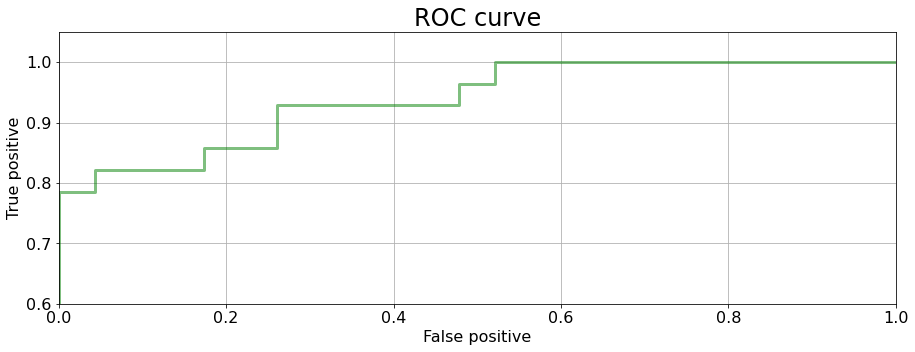

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

plt.plot(fpr, tpr, color='green', lw=3, label='ROC curve (area = %0.3f)' % roc_auc, alpha=0.5)

 #настроим область отображения, размеры шрифта, подписи и тд
plt.xlim([0.0, 1.0])
plt.ylim([0.6, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False positive', fontsize=16)
plt.ylabel('True positive', fontsize=16)
plt.title('ROC curve', fontsize=24)
plt.show()

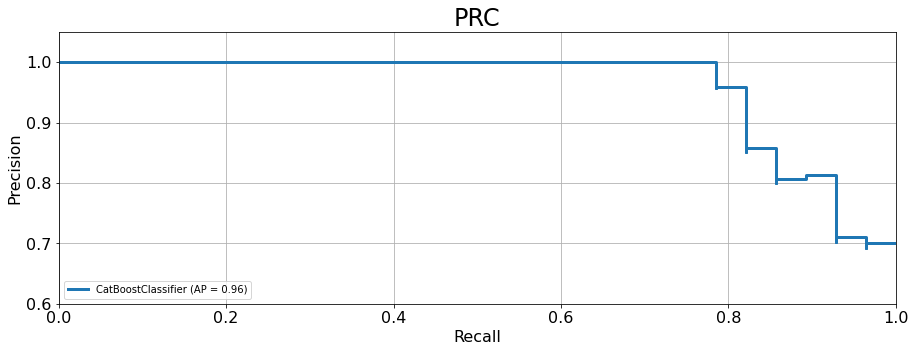

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))


sklearn.metrics.plot_precision_recall_curve(model, X_test, y_test, ax=ax, lw = 3)

plt.xlim([0.0, 1.0])
plt.ylim([0.6, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)
plt.title('PRC', fontsize=24)

plt.show()

In [ ]:
#RPC AUC
s = sklearn.metrics.average_precision_score(pd.factorize(y_test)[0], model.predict_proba(X_test)[:,0]) 
print('RPC-AUC: ' + str(s))

RPC-AUC: 0.9213305046695979
